We want to convert the routines below to use the BasicCameraGUI as the base and test with the existing polar mapping methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.visualisers.camera_gui import BasicCameraGUI, display, DecomposeFrame

In [2]:
from src.sources.polar_mapping import (
    generateLUT, setup_reduced_res, reduce_resolution, 
    convert_image, forward_quad, generate_backLUT, back_convert_image
)

In [3]:
class PolarGUI(BasicCameraGUI):
    """Convert base camera into polar co-ordinates."""
    
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src)
        
        # Capture a frame to set image sizes
        _, frame = self.cam.read()
        Y = frame[:, :, 0]
        self.centre = np.asarray(Y.shape) // 2
        self.radius = self.centre.max()
        self.phase_width = phase_width
        # Generate LUT
        self.LUT = generateLUT(self.radius, phase_width=phase_width)
        
    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        converted = convert_image(Y, self.LUT)
        display(converted, self.original_image)
        return converted

In [4]:
polar = PolarGUI()
polar.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 89, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 88, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 82, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

This appears to work.
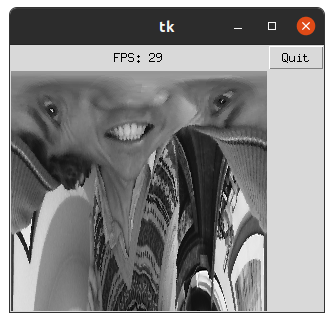

Now we want to split the visual field - does our forward quad do this?

In [5]:
class QuadPolar(PolarGUI):
    """Show different portions of visual field."""
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        
        # Add a decompose frame to show quad
        self.frame = DecomposeFrame(self.window, width=128, height=128)
        
    def update_image(self):
        # Get frame
        converted = super().update_image()
        images = forward_quad(converted)
        self.frame.update(images)
        return converted

In [6]:
qp = QuadPolar()
qp.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 89, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 88, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 82, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

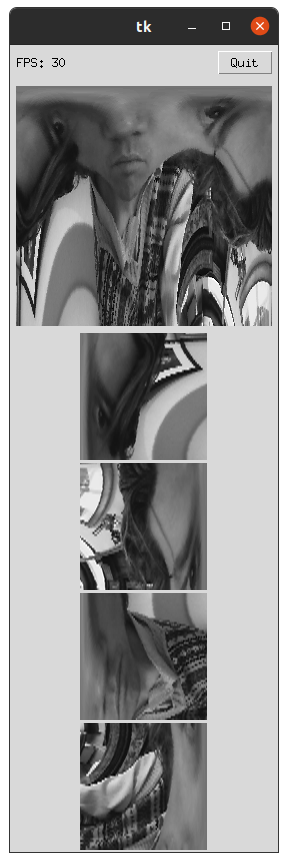

Now need to convert this last reduced GUI...

In [7]:
import tkinter as tk

class CamGUIReduced(QuadPolar):

    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        # Setup reduced resolution parameters
        self.precomputed = setup_reduced_res(self.phase_width)
        # frame and label for the reduced resolution frame
        reduced_frame = tk.Frame(self.window)
        reduced_frame.pack(side=tk.LEFT, expand=True, fill=tk.BOTH)
        self.reduced_image = tk.Label(reduced_frame)
        self.reduced_image.pack(padx=5, pady=5)

    def update_image(self):
        converted = super().update_image()
        # Show reduced image
        output_list, output_image = reduce_resolution(
            converted, output_display=True, precomputed=self.precomputed)
        display(output_image, self.reduced_image)
        return output_image

In [8]:
reduced = CamGUIReduced()
reduced.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 89, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 88, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 82, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

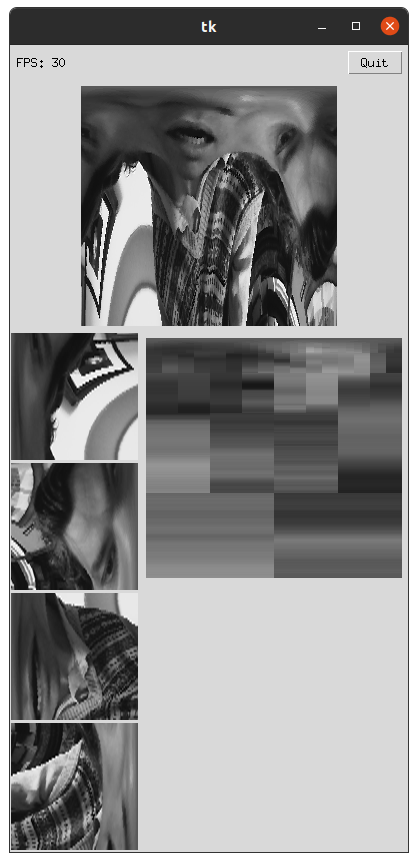

Now let's try polar and decomposition and PBT?

We need to mix DeComGUI and PolarGUI. Better to expand the polar GUI?

Let's first make DeComGUI inherit from BasicCameraGUI

In [9]:
import cv2
from src.var_processor.surface_stage import decompose

class DeComGUI(BasicCameraGUI):
    """GUI to look at decompositions."""

    def __init__(self, src=0, stages=7):
        # Call parent init
        super().__init__(src)

        # Hardcode decomposition stages for now
        self.num_of_stages = stages

        # Create a frame for each stage and pack vertically
        self.frames = [
            DecomposeFrame(self.window, width=128, height=128)
            for _ in range(self.num_of_stages)]

    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        image = Y
        image_lists = [[Y]]
        # Iteratively decompose
        for _ in range(self.num_of_stages - 1):
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # Scale and convert back to 8-bit
            # Convert A to unsigned 8 bit
            images[0] = (images[0]).astype(np.uint8)
            # For others shift to positive and apply colour map
            # heatmap = cv2.applyColorMap(image, cv2.COLORMAP_HOT)
            images = [images[0]] + [
                cv2.applyColorMap((i + 128).astype(np.uint8), cv2.COLORMAP_JET) for i in images[1:]
            ]
            image_lists.append(images)
            # Set the next image as the average of the set
            image = images[0]

        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
        return Y

In [48]:
decom = DeComGUI()
decom.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 89, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 88, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 82, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

In [7]:
from src.var_processor.pb_threshold import pb_threshold, pb_residual_threshold

class PBTDeComGUI(DeComGUI):
    """Apply PBT to the surfaces (separately to A and differences)."""

    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        image = Y
        image_lists = [[Y]]
        # Iteratively decompose
        for _ in range(self.num_of_stages + 4 - 1):
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # Set A as input for next stage
            image = images[0]
            # PBT A - remember to cast to 8-bit
            A_pbt = pb_threshold(images[0].astype(np.uint8)) * 255
            # PBT differences
            diffs = list()
            for i in images[1:]:
                thresholded = pb_residual_threshold(i)
                rescaled = (thresholded * 127) + 127
                color_mapped = cv2.applyColorMap(rescaled.astype(np.uint8), cv2.COLORMAP_JET)
                diffs.append(color_mapped)
            images = [A_pbt.astype(np.uint8)] + diffs
            image_lists.append(images)

        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
        return Y

In [50]:
pb_decom = PBTDeComGUI(stages=7)
pb_decom.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 89, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 88, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 82, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

Use PolarGUI as base and add in methods from the DeComPBT...

In [8]:
class PolarPBT(PolarGUI):
    
    def __init__(self, src=0, stages=7):
        # Call parent init
        super().__init__(src)

        # Hardcode decomposition stages for now
        self.num_of_stages = stages

        # Create a frame for each stage and pack vertically
        self.frames = [
            DecomposeFrame(self.window, width=128, height=128)
            for _ in range(self.num_of_stages)]
        
    def update_image(self):
        # Get frame
        converted = super().update_image()
        image = converted
        image_lists = [[image]]
        # Iteratively decompose
        for _ in range(self.num_of_stages + 4 - 1):
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # Set A as input for next stage
            image = images[0]
            # PBT A - remember to cast to 8-bit
            A_pbt = pb_threshold(images[0].astype(np.uint8)) * 255
            # PBT differences
            diffs = list()
            for i in images[1:]:
                thresholded = pb_residual_threshold(i)
                rescaled = (thresholded * 127) + 127
                color_mapped = cv2.applyColorMap(rescaled.astype(np.uint8), cv2.COLORMAP_JET)
                diffs.append(color_mapped)
            images = [A_pbt.astype(np.uint8)] + diffs
            image_lists.append(images)

        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
        return converted

In [9]:
ppb_decom = PolarPBT(stages=4)
ppb_decom.run()

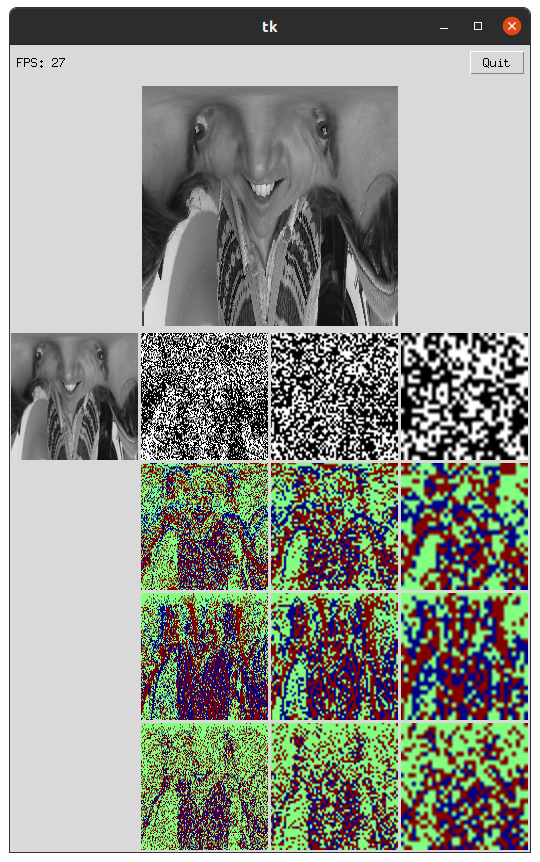

What is interesting about a polar decomposition is that H and V are very similar as most features are round...

We can just use a single differential?

Todo:
* Diffs as another stage in between.
* Reconstruction in parallel.
* Toggle components of reconstruction.
* ~~Break into quadrants.~~

In [10]:
class PBTPolarQuad(PolarGUI):
    """Show different portions of visual field."""
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        
        # Add a decompose frame to show quad
        self.quad_frame = DecomposeFrame(self.window, width=128, height=128)

        # Create a frame for each quad and pack vertically
        self.decom_frames = [
            DecomposeFrame(self.window, width=128, height=128)
            for _ in range(4)]                  
        
    def update_image(self):
        # Get frame
        converted = super().update_image()
        quad_images = forward_quad(converted)
        self.quad_frame.update(quad_images)
        for quad, frame in zip(quad_images, self.decom_frames): 
            image = quad
            image_lists = [[image]]
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # PBT A - remember to cast to 8-bit
            A_pbt = pb_threshold(images[0].astype(np.uint8)) * 255
            # PBT differences
            diffs = list()
            for i in images[1:]:
                thresholded = pb_residual_threshold(i)
                rescaled = (thresholded * 127) + 127
                color_mapped = cv2.applyColorMap(rescaled.astype(np.uint8), cv2.COLORMAP_JET)
                diffs.append(color_mapped)
            images = [A_pbt.astype(np.uint8)] + diffs
            frame.update(images)
            
        return converted

In [44]:
polar_quad = PBTPolarQuad()
polar_quad.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 89, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 88, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 82, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

Left todo:
* differences and reconstruction - look at these separately.

# Reduced

The reduced version actually helps the scaling and speed problems. We need to fold it into the splitting of the visual field and the decomposition.

Can we build a reconstruction from this data?
* We have backward quad to rebuild from the four quadrants.

In [11]:
polar = PolarGUI()

In [12]:
converted = polar.update_image()
output_list, output_image = reduce_resolution(
            converted, output_display=True)

In [13]:
output_list

[array([[160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160],
        [159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 159],
        [158, 158, 158, 158, 158, 157, 157, 157, 157, 157, 157, 158, 158,
         158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158,
         158, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 159, 159,
         159, 159, 159, 159, 160, 160, 160, 16

In [14]:
for array in output_list:
    print(array.shape)

(5, 64)
(10, 32)
(20, 16)
(40, 8)
(80, 4)
(85, 2)


So to get the different quadrants, we just split each array into 4 (we'd need to just copy the last one).

In [15]:
quads = np.split(output_list[0], 4, axis=1)

In [18]:
for i, quad in enumerate(quads):
    print(i, quad.shape)

0 (80, 1)
1 (80, 1)
2 (80, 1)
3 (80, 1)


In [19]:
for array in output_list:
    if array.shape[1] >= 4:
        quads = np.split(array, 4, axis=1)
        for q in quads:
            print(q.shape)

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(10, 8)
(10, 8)
(10, 8)
(10, 8)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(40, 2)
(40, 2)
(40, 2)
(40, 2)
(80, 1)
(80, 1)
(80, 1)
(80, 1)


Do we decompose before or after reduction?

If we imagine that the Thalamus models A and the cortex models the difference(s) then maybe before? 

In [20]:
# Can we just calibrate the reduction to have 4 as the width of the last section? Makes quad split easier...
groupings, grouping_ranges, spacings = setup_reduced_res(256)

In [21]:
print(groupings, grouping_ranges, spacings)

[  4   8  16  32  64 128] [array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
       156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204,
       208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252]), array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200,
       208, 216, 224, 232, 240, 248]), array([  0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192,
       208, 224, 240]), array([  0,  32,  64,  96, 128, 160, 192, 224]), array([  0,  64, 128, 192]), array([  0, 128])] [  5  10  20  40  80 160]


In [22]:
[[]] * 4

[[], [], [], []]

In [23]:
image_width = 256
# Get width of image as a power of 2
base_power = int(np.log2(image_width))
# Highest resolution is set by rough science
# But we need to change this based on
start_group = (base_power-6)
# Determine the number of pixels to group
# across the angular (rotation) dimension
groupings = 2**(np.arange(start_group, base_power))
print(base_power, start_group, groupings)

8 2 [  4   8  16  32  64 128]


Easier just to copy/ignore the last data!

In [24]:
print (np.arange(4) // 2) 

[0 0 1 1]


In [25]:
def reduced_to_quad(output_list):
    """Split a reduced image into visual field quadrants."""
    # Create blank list with 4 items
    quad_list = [list() for _ in range(4)]
    for array in output_list:
        if array.shape[1] >= 4:
            quads = np.split(array, 4, axis=1)
            for i, quad in enumerate(quads):
                quad_list[i].append(quad)
        # If there are only two entries
        elif array.shape[1] == 2:
            # This is a bit of a fudge - can be better
            halves = np.split(array, 2, axis=1)    
            for i, ql in enumerate(halves):
                quad_list[i].append(halves[i//2])
    return quad_list

In [26]:
# DON'T USE *4 this create a memroy view not a new array
quad_list = [[], [], [], []]
assert len(quad_list) == 4
print(quad_list)

[[], [], [], []]


In [27]:
quad_list[0].append(0); print(quad_list); quad_list[1].append(1); print(quad_list); quad_list[2].append(2); print(quad_list)

[[0], [], [], []]
[[0], [1], [], []]
[[0], [1], [2], []]


In [28]:
quads = reduced_to_quad(output_list)

In [29]:
for i, quad in enumerate(quads):
    print(f"Quad {i}")
    for array in quad:
        print(array.shape)

Quad 0
(5, 16)
(10, 8)
(20, 4)
(40, 2)
(80, 1)
(85, 1)
Quad 1
(5, 16)
(10, 8)
(20, 4)
(40, 2)
(80, 1)
(85, 1)
Quad 2
(5, 16)
(10, 8)
(20, 4)
(40, 2)
(80, 1)
Quad 3
(5, 16)
(10, 8)
(20, 4)
(40, 2)
(80, 1)


That's better. Now how do we flatten this or apply a 2D decomposition?

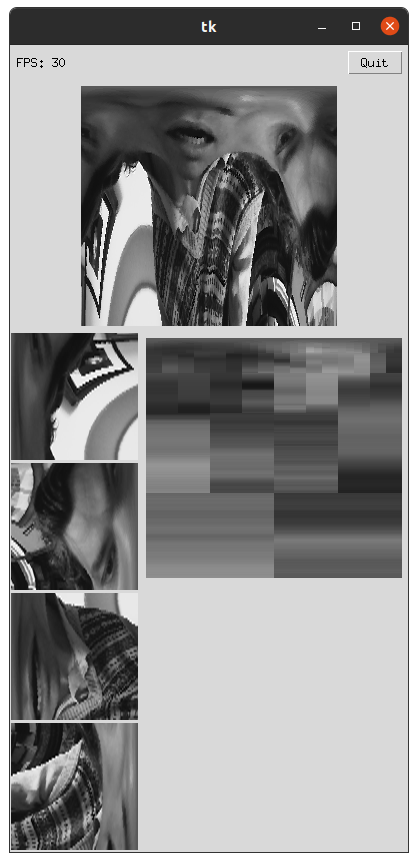

In [30]:
polar.quit_()

What happens when we reverse map the reduced image?

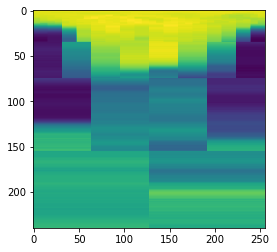

In [31]:
plt.imshow(output_image)

In [32]:
backLUT = generate_backLUT(256)

In [33]:
output_image.shape

(240, 256)

pad_width{sequence, array_like, int}
Number of values padded to the edges of each axis. ((before_1, after_1), … (before_N, after_N)) unique pad widths for each axis. ((before, after),) yields same before and after pad for each axis. (pad,) or int is a shortcut for before = after = pad width for all axes.

In [34]:
padding = ((0, 16), (0, 0))
padded = np.pad(output_image, padding, mode="edge")
padded.shape

(256, 256)

In [35]:
back_image = back_convert_image(padded, backLUT)

In [36]:
# Debug back_conversion
polar_image = padded
range_radius, range_angles = polar_image.shape[:2]
print(range_radius, range_angles)
# Determine LUT size
rows, cols, _ = backLUT.shape
# Adjust radius so it is within the scale of the polar image
radius = np.clip(backLUT[..., 0], 0, range_radius-1).astype(int)
print(radius)
# Convert radian range to discrete pixel range
angles = (
        (backLUT[..., 1]+np.pi)*(1/(2*np.pi))*(range_angles-1)
    ).astype(int)
print(angles)

256 256
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[ 31  31  32 ...  95  95  95]
 [ 31  31  31 ...  95  95  95]
 [ 31  31  31 ...  95  95  95]
 ...
 [223 223 223 ... 159 159 159]
 [223 223 223 ... 159 159 159]
 [223 223 223 ... 159 159 159]]


In [37]:
# If multiple components
if polar_image.ndim == 3:
    output_image = polar_image[radius, angles, :]
else:
    output_image = polar_image[radius, angles]
# Image is upside down so flip the right way around
output_image = np.flip(output_image)

<IPython.core.display.Javascript object>


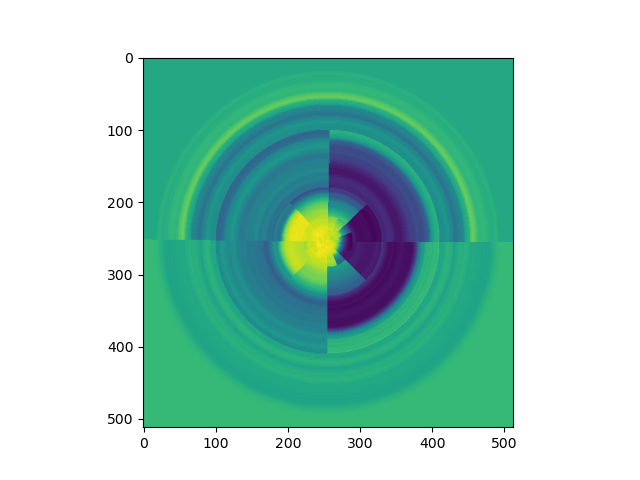

In [38]:
%matplotlib notebook
plt.imshow(output_image)

In [39]:

def back_convert_image(polar_image, backLUT):
    """Convert a polar image to cartesian using the backLUT.

    Output image is square with dimensions 2*radius in each dimension.


    Args:
        polar_image - numpy array with radius along rows and
            angles along columns.
        backLUT - a numpy array generated as above.
    Returns:
        output_image - a numpy array representing the cartesian image.

    """
    # Determine image size
    range_radius, range_angles = polar_image.shape[:2]
    # Determine LUT size
    rows, cols, _ = backLUT.shape
    # Adjust radius so it is within the scale of the polar image
    radius = np.clip(backLUT[..., 0], 0, range_radius-1).astype(int)
    # Convert radian range to discrete pixel range
    angles = (
        (backLUT[..., 1]+np.pi)*(1/(2*np.pi))*(range_angles-1)
    ).astype(int)
    # If multiple components
    if polar_image.ndim == 3:
        output_image = polar_image[radius, angles, :]
    else:
        output_image = polar_image[radius, angles]
    # Image is upside down so flip the right way around
    return output_image


In [40]:
# Add the reconstructed version

class CamGUIReducedRecon(CamGUIReduced):

    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        # Setup backLUt
        self.backLUT = generate_backLUT(phase_width)
        # frame and label for the reconstruction
        recon_frame = tk.Frame(self.window)
        recon_frame.pack(side=tk.LEFT, expand=True, fill=tk.BOTH)
        self.recon_image = tk.Label(recon_frame)
        self.recon_image.pack(padx=5, pady=5)

    def update_image(self):
        output_image = super().update_image()
        # Show reconstructed image
        # Add padding if not square
        pad_value = output_image.shape[1] - output_image.shape[0]
        padding = ((0, pad_value), (0, 0))
        padded = np.pad(output_image, padding, mode="edge")
        back_image = back_convert_image(padded, self.backLUT)
        display(np.rot90(back_image, k=-1), self.recon_image)
        return back_image

In [ ]:
cam = CamGUIReducedRecon()
cam.run()

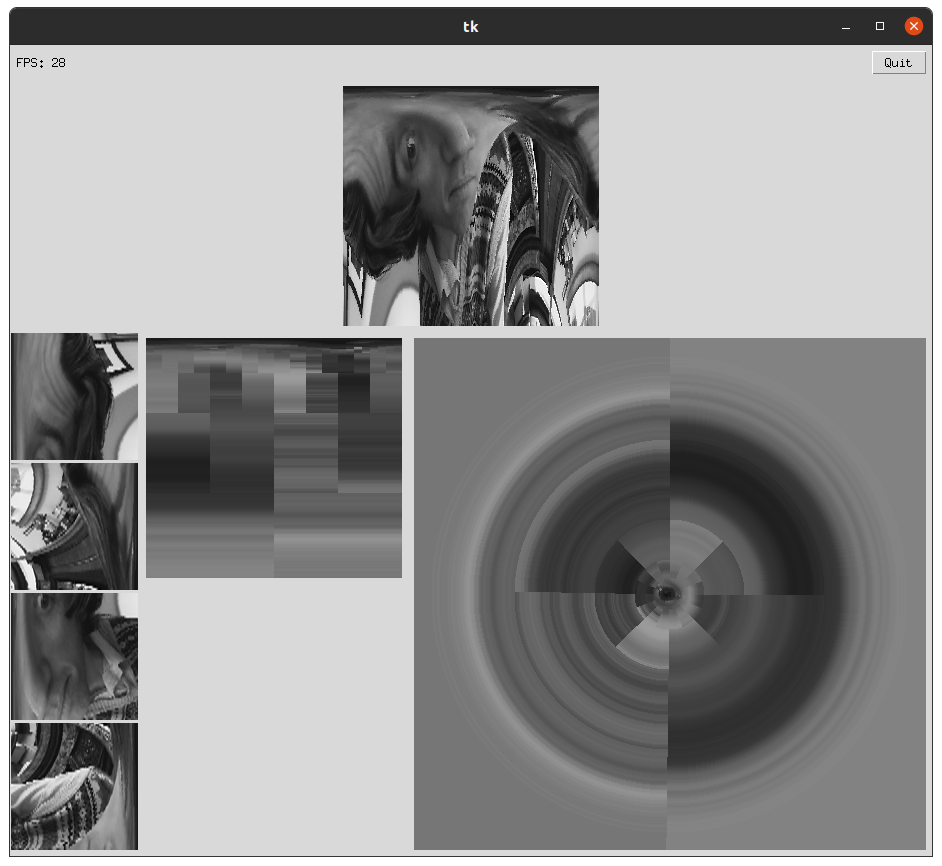

How do our decompositions work when we have this polar arrangement?

At the most detailed we have 5 rows of 16 pixels

In [49]:
quads[0]

[array([[ 73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,
          73,  73,  73],
        [ 72,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,
          73,  73,  73],
        [ 71,  71,  71,  71,  71,  78,  86,  86,  86,  86,  86,  87,  87,
          87,  87,  87],
        [ 73,  73,  73,  79,  85,  85,  85,  89,  95, 104, 104, 104, 102,
         100, 100, 100],
        [ 74,  73,  75,  84,  84,  86,  89,  91,  95, 102, 102, 105, 105,
         105, 105, 105]], dtype=uint64),
 array([[ 77,  84,  88,  96, 104, 116, 116, 114],
        [ 78,  86,  93, 105, 115, 123, 121, 119],
        [ 78,  86,  99, 113, 120, 130, 131, 131],
        [ 77,  86, 107, 117, 126, 130, 132, 135],
        [ 79,  98, 114, 121, 129, 130, 132, 135],
        [ 82, 103, 118, 123, 127, 130, 133, 135],
        [ 86, 104, 119, 127, 127, 129, 133, 134],
        [ 89, 110, 122, 128, 128, 130, 132, 134],
        [ 92, 115, 125, 132, 130, 129, 131, 133],
        [ 97, 117, 128, 133, 130, 128, 

In [64]:
%%timeit
quad_diff = list()
for portion in quads[0]:
    quad_diff.append(np.diff(portion, axis=0))

22.8 µs ± 338 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [51]:
for d in quad_diff:
    print(d.shape)

(4, 16)
(9, 8)
(19, 4)
(39, 2)
(79, 1)
(84, 1)


Is it quicker to use a list of array or one big empty array?

In [54]:
total_shape = sum([portion.shape[0] for portion in quads[0]])
max_width = max([portion.shape[1] for portion in quads[0]])
print(total_shape, max_width)

240 16


In [57]:
# Convert the list into a square array
quad_array = np.zeros(shape=(total_shape, max_width))
start = 0
for portion in quads[0]:
    end = start+portion.shape[0]
    quad_array[start:end, 0:portion.shape[1]] = portion
    start = end

In [58]:
quad_array

array([[ 73.,  73.,  73., ...,  73.,  73.,  73.],
       [ 72.,  73.,  73., ...,  73.,  73.,  73.],
       [ 71.,  71.,  71., ...,  87.,  87.,  87.],
       ...,
       [124.,   0.,   0., ...,   0.,   0.,   0.],
       [125.,   0.,   0., ...,   0.,   0.,   0.],
       [126.,   0.,   0., ...,   0.,   0.,   0.]])

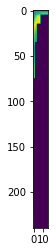

In [61]:
plt.imshow(quad_array)

In [63]:
%%timeit
d_1 = np.diff(quad_array, axis=0)

3.94 µs ± 13.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Array is 5x faster.

<IPython.core.display.Javascript object>


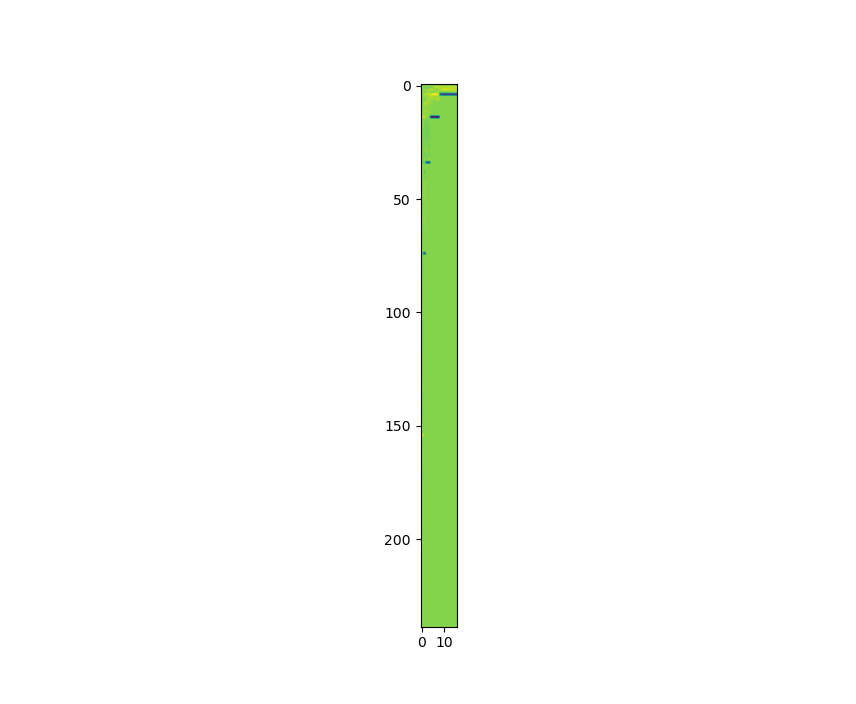

In [67]:
%matplotlib notebook
d_1 = np.diff(quad_array, axis=0)
plt.imshow(d_1)